# Fake Prediction

In [10]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
# import keras_cv

from tqdm.auto import tqdm
from tensorflow import keras
#from keras_cv import bounding_box
#from keras_cv import visualization
from keras.models import load_model
import numpy as np
from keras.models import Sequential, model_from_json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from keras.callbacks import EarlyStopping
import re

In [11]:
he = 0
print(bool(he))

False


In [12]:
path = "../data_zettel/Annotations"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path, file_name)
        for file_name in os.listdir(path)
        if file_name.endswith(".xml")
    ]
)
 
# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path, file_name)
        for file_name in os.listdir(path)
        if file_name.endswith(".jpg")
    ]
)

In [13]:
def create_box(bbox):
    xmin = float(bbox.find("xmin").text)
    ymin = float(bbox.find("ymin").text)
    xmax = float(bbox.find("xmax").text)
    ymax = float(bbox.find("ymax").text)
    return [xmin, ymin, xmax, ymax]

In [14]:
def parse_annotation_fake(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = f'../data_zettel/filled_resized/{image_name}'

    boxes = []
    classes = []
    main_classes = []
    sub_classes = []
    main_boxes = []
    sub_boxes = []
    values = []
    
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)
        
        bbox = obj.find("bndbox")
        boxes.append(create_box(bbox))
        
        # main labels
        if (cls == 'Wohnsitz_waehrend_Ausbildung') or (cls == 'Ausbildung') or (cls == 'Person') or (cls == 'Wohnsitz'):
            main_classes.append(cls)
            bbox = obj.find("bndbox")
            main_boxes.append(create_box(bbox))
        else:
            attributes = obj.findall("attributes/attribute")
            for attribute in attributes:
                value_element = attribute.find("value")
                value = value_element.text
                if value is None:
                    continue
                elif value is None or value.lower() in ["true", "false"]:
                    continue
                
                # Versuche, den Wert in einen Float zu konvertieren
                try:
                    float_value = float(value)
                    int_value = int(float_value)
                    values.append(str(int_value))  # Hier wird der Integer in einen String umgewandelt
                except ValueError:
                    # Wenn die Konvertierung fehlschlägt, füge den originalen Wert zur Liste hinzu
                    values.append(value)
                break
            
            bbox = obj.find("bndbox")
            sub_boxes.append(create_box(bbox))
            sub_classes.append(cls)
    return image_path,sub_boxes,sub_classes, main_boxes,main_classes,values

In [15]:
from bounding_box.model import load_weight_model, predict_image,plot_image, get_templated_data, edit_sub_boxes_cut_links, edit_sub_boxes_cut_top
from bounding_box.template import build_templating_data
org_ms_boxes_person, org_ms_boxes_wohnsitz, org_ms_boxes_ausbildung, org_ms_boxes_wwa, person_class_ids, ausbildung_class_ids, wohnsitz_class_ids, wwa_class_ids, widthOrgImag, heightOrgImag = build_templating_data()



Using TensorFlow backend


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [16]:
from bounding_box.model import load_weight_model, predict_image,plot_image, get_templated_data, edit_sub_boxes_cut_links, edit_sub_boxes_cut_top
from bounding_box.template import build_templating_data


In [17]:
def sort_box_to_class(sub_boxes, sub_classes_string, sub_classes_numbers, values):
    new_sub_boxes = []
    new_values = []
    new_sub_box_classes = []
    cls_values = [8, 0, 5, 6, 1, 3, 4,
                  14, 16, 17, 9, 11, 15, 18, 19, 20, 21, 
                  22, 25, 26, 23, 24, 27, 28, 29, 30, 31, 33, 34]
    comment_strings = [
        "Ausbildung_Staette",
        "Ausbildung_Klasse",
        "Ausbilung_Abschluss",
        "Ausbildung_Vollzeit",
        "Ausbildung_Antrag_gestellt_ja",
        "Ausbildung_Amt",
        "Ausbildung_Foerderungsnummer",
        "Person_Name",
        "Person_Vorname",
        "Person_Geburtsname",
        "Person_Geburtsort",
        "Person_Geburtsdatum",
        "Person_Familienstand",
        "Person_Familienstand_seit",
        "Person_Stattsangehörigkeit_eigene",
        "Person_Stattsangehörigkeit_Ehegatte",
        "Person_Kinder",
        "Wohnsitz_Strasse",
        "Wohnsitz_Hausnummer",
        "Wohnsitz_Adresszusatz",
        "Wohnsitz_Land",
        "Wohnsitz_Postleitzahl",
        "Wohnsitz_Ort",
        "Wohnsitz_waehrend_Ausbildung_Strasse",
        "Wohnsitz_waehrend_Ausbildung_Hausnummer",
        "Wohnsitz_waehrend_Ausbildung_Adresszusatz",
        "Wohnsitz_waehrend_Ausbildung_Land",
        "Wohnsitz_waehrend_Ausbildung_Postleitzahl",
        "Wohnsitz_waehrend_Ausbildung_ort"
    ]
    for x,sub_classes_number in enumerate(sub_classes_numbers):
        for i, cls_value in enumerate(cls_values):
            if sub_classes_number == cls_value:
                temp_class_string = comment_strings[i]
                for j,sub_class_string in enumerate(sub_classes_string):
                    if temp_class_string == sub_class_string:
                        if values[j] is not None:
                            new_sub_boxes.append(sub_boxes[x])
                            new_values.append(values[j]) 
                            new_sub_box_classes.append(temp_class_string)
                           
                            
               
    return new_sub_boxes, new_values, new_sub_box_classes

In [28]:
from collections import namedtuple
ImageInfo = namedtuple('ImageInfo', ['path', 'boxes', 'values', 'classes'])
image_list = []
for xml_file in tqdm(xml_files): 
    image_path,sub_boxes,sub_classes, main_boxes, main_classes, values = parse_annotation_fake(xml_file)
    confidence = [[1, 0.9, 0.9, 0.9]]
    print(main_classes)
    main_classes = [[0,1,2,3]]
    main_boxes = [main_boxes]
    ausbildung, person, wohnsitz, wwa, best_predicted = get_templated_data(main_boxes, confidence, main_classes, org_ms_boxes_person,
                                                                       org_ms_boxes_wohnsitz, org_ms_boxes_ausbildung,
                                                                       org_ms_boxes_wwa, person_class_ids,
                                                                       ausbildung_class_ids, wohnsitz_class_ids,
                                                                       wwa_class_ids)
    
    ausbildung, person, wohnsitz, wwa = edit_sub_boxes_cut_top(ausbildung, person, wohnsitz, wwa)
    sub_boxes = ausbildung[0] + person[0] + wohnsitz[0] + wwa[0]
    sub_classes_number = ausbildung[1] + person[1] + wohnsitz[1] + wwa[1]
    
    new_sub_boxes, new_values, sub_classes_string = sort_box_to_class(sub_boxes,sub_classes,sub_classes_number,values)
    #sub_boxes = edit_sub_boxes_cut_top(ausbildung, person, wohnsitz, wwa)
    #sub_boxes = edit_sub_boxes_cut_links(ausbildung, person, wohnsitz, wwa)
    
    image = ImageInfo(path=image_path, boxes=new_sub_boxes, values=new_values,classes=sub_classes_string)
    numbers_to_check = ["31", "32", "33", "35", "36"]
    # Check if the string does not contain any of the specified numbers
    does_not_contain_numbers = all(number not in image.path for number in numbers_to_check)
    
    if does_not_contain_numbers:
        
            image_list.append(image)
 

  0%|          | 0/81 [00:00<?, ?it/s]

['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz', 'Wohnsitz_waehrend_Ausbildung']
['Ausbildung', 'Person', 'Wohnsitz


### Crop ROI

In [29]:
print(len(image_list[5].boxes))

28


In [30]:
# Crop ROI
save_path_crops = "../data_zettel/cropped_images"

import cv2
def crop(xmin, ymin, xmax, ymax, image_path):
    try:
        image = cv2.imread(image_path)
        xmin = int(round(xmin))
        ymin = int(round(ymin))
        xmax = int(round(xmax))
        ymax = int(round(ymax))
        imgCropped = image[ymin:ymax, xmin:xmax]
    except:
        imgCropped = None
        
    return imgCropped


for index, image in enumerate(image_list):
    boxes = image.boxes
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = np.array(box)
        imgCropped = crop(xmin, ymin, xmax, ymax, image.path)
        if imgCropped is not None:
            if (image.values[i] != "1" and image.values[i] != "0" and image.values[i] != "355" 
                    and image.values[i] != "356" and image.values[i] != "357" and image.values[i] != "358"and image.values[i] != "359"and image.values[i] != "b"
                    and image.values[i] != '' and image.values[i] != 'X'):
                try:
                    cv2.imwrite(f"{save_path_crops}/{index}_{i}.jpg", imgCropped)
                    with open(f"{save_path_crops}/{index}_{i}.txt", 'w', encoding='utf-8') as file:
                        image.values[i] = image.values[i].replace(" ", "|")
                         
                        file.write(image.values[i])
                        print(f'{image.classes[i]}: {image.values[i]}')
                except:
                    continue

Ausbildung_Foerderungsnummer: 217778210341982
Ausbildung_Amt: NR
Ausbildung_Staette: Worskpace|Hochschule
Ausbilung_Abschluss: Master
Ausbildung_Klasse: Arts
Person_Familienstand: 4
Person_Vorname: Linda
Person_Geburtsname: tronan
Person_Geburtsort: Pindra
Person_Geburtsdatum: 11112004
Person_Stattsangehörigkeit_eigene: NR
Person_Familienstand_seit: 21012001
Person_Name: Patron
Wohnsitz_Postleitzahl: 49928
Wohnsitz_Strasse: Puffer|Straße
Wohnsitz_Hausnummer: 21
Wohnsitz_Land: NR
Wohnsitz_waehrend_Ausbildung_Strasse: Lüpfer|Weg
Wohnsitz_waehrend_Ausbildung_Postleitzahl: 21998
Wohnsitz_waehrend_Ausbildung_Hausnummer: 42
Ausbildung_Foerderungsnummer: 201022467349110
Ausbildung_Amt: BE
Ausbildung_Staette: Sandrin|Universität
Ausbilung_Abschluss: Bachelor
Ausbildung_Klasse: Chimie
Person_Familienstand: 5
Person_Vorname: Zura
Person_Geburtsname: Bana
Person_Geburtsort: Lindor
Person_Geburtsdatum: 1212001
Person_Stattsangehörigkeit_eigene: Ar
Person_Name: Zama
Wohnsitz_Postleitzahl: 92187
Woh

# Handwriting

In [31]:
# Unsere Klassen
#import handwriting.load_data as load_data
import handwriting.load_transfer_data as load_transfer_data
import handwriting.testing_models as testing_models # Use: build_model9v3(img_width, img_height, char) 
import utils.configs as cfg
#Imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pathlib
import random
import time
import os

## Config

In [32]:
config_path = "../utils/configs.json"

config = cfg.Config(config_path)

# Pipeline
TRANSFER = bool(config.get_pipeline_parameter()["transfer"])

# Model Parameter
MODEL_SAVE = bool(config.get_model_parameter()["save"])
MODEL_NAME = config.get_model_parameter()["name"]
IMAGE_WIDTH = config.get_model_parameter()["width"] # default: 1024
IMAGE_HEIGHT = config.get_model_parameter()["height"] # default: 128

# Directory Parameter
MODEL_DIR_NAME = pathlib.Path(os.getcwd()).joinpath(config.get_directory_parameter()["model_dir"])
TEST_RESULT_DIR_NAME = pathlib.Path(os.getcwd()).joinpath(config.get_directory_parameter()["test_dir"])
DATA_BASE_PATH = config.get_directory_parameter()["data_base_path"]

# Training Parameter
SAVE_HISTORY = bool(config.get_training_parameter()["save_history"])
EPOCHS = config.get_training_parameter()["epochs"]
BATCH_SIZE = config.get_training_parameter()["batch_size"] # default: 32 - 48
TF_SEED = config.get_training_parameter()["tf_seed"] # default: 42
LEARNING_RATE = config.get_training_parameter()["learning_rate"]
PATIENCE = config.get_training_parameter()["patience"] # default: 3

## Load Data

In [33]:
# Default: seed = 42
# np.random.seed(TF_SEED)
# tf.random.set_seed(TF_SEED)

# Random
#seed = random.randint(1, 1000)
#np.random.seed(seed)
#tf.random.set_seed(seed)
print(LEARNING_RATE)
print(TF_SEED)

0.001
42


In [34]:
#load_data.print_samples(DATA_BASE_PATH)
if False: # IAM Dataset
    x_train_img_paths, y_train_labels = load_data.get_train_data()
    x_val_img_paths, y_val_labels = load_data.get_validation_data()
    #x_test_img_paths, y_test_labels = load_data.get_test_data()
else:
    x_train_img_paths, y_train_labels = load_transfer_data.get_train_data()
    x_val_img_paths, y_val_labels = load_transfer_data.get_validation_data()

In [35]:
print(f"Training path: {x_train_img_paths[0:2]}", y_train_labels[0:2])
print(f"Validation path: {x_val_img_paths[0:2]}", y_val_labels[0:2])
#print(f"Testing path: {x_test_img_paths[0:2]}", y_test_labels[0:2])

Training path: ['../data_zettel/cropped_images/21_18.jpg', '../data_zettel/cropped_images/5_12.jpg'] ['23208', '21112101']
Validation path: ['../data_zettel/cropped_images/71_22.jpg', '../data_zettel/cropped_images/44_10.jpg'] ['DE', 'Pretoria']


## Create Dataset

In [36]:
# Has to be here because load data functions need to be called before
import handwriting.tokenizer as tokenizer
import handwriting.custom_image_generator as cgi

# takes eternity
#x_train, y_train = tokenizer.prepare_data(x_train_img_paths, y_train_labels) 
#x_test, y_test = tokenizer.prepare_data(x_test_img_paths, y_test_labels)

#train_generator = cgi.CustomImageGenerator(x_train_img_paths, y_train_labels, BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT)

train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels, (IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
#test_ds = tokenizer.prepare_dataset(x_test_img_paths, y_test_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
#aug_train_ds = tokenizer.prepare_augmented_dataset(x_train_img_paths, y_train_labels, BATCH_SIZE)

## Show Examples

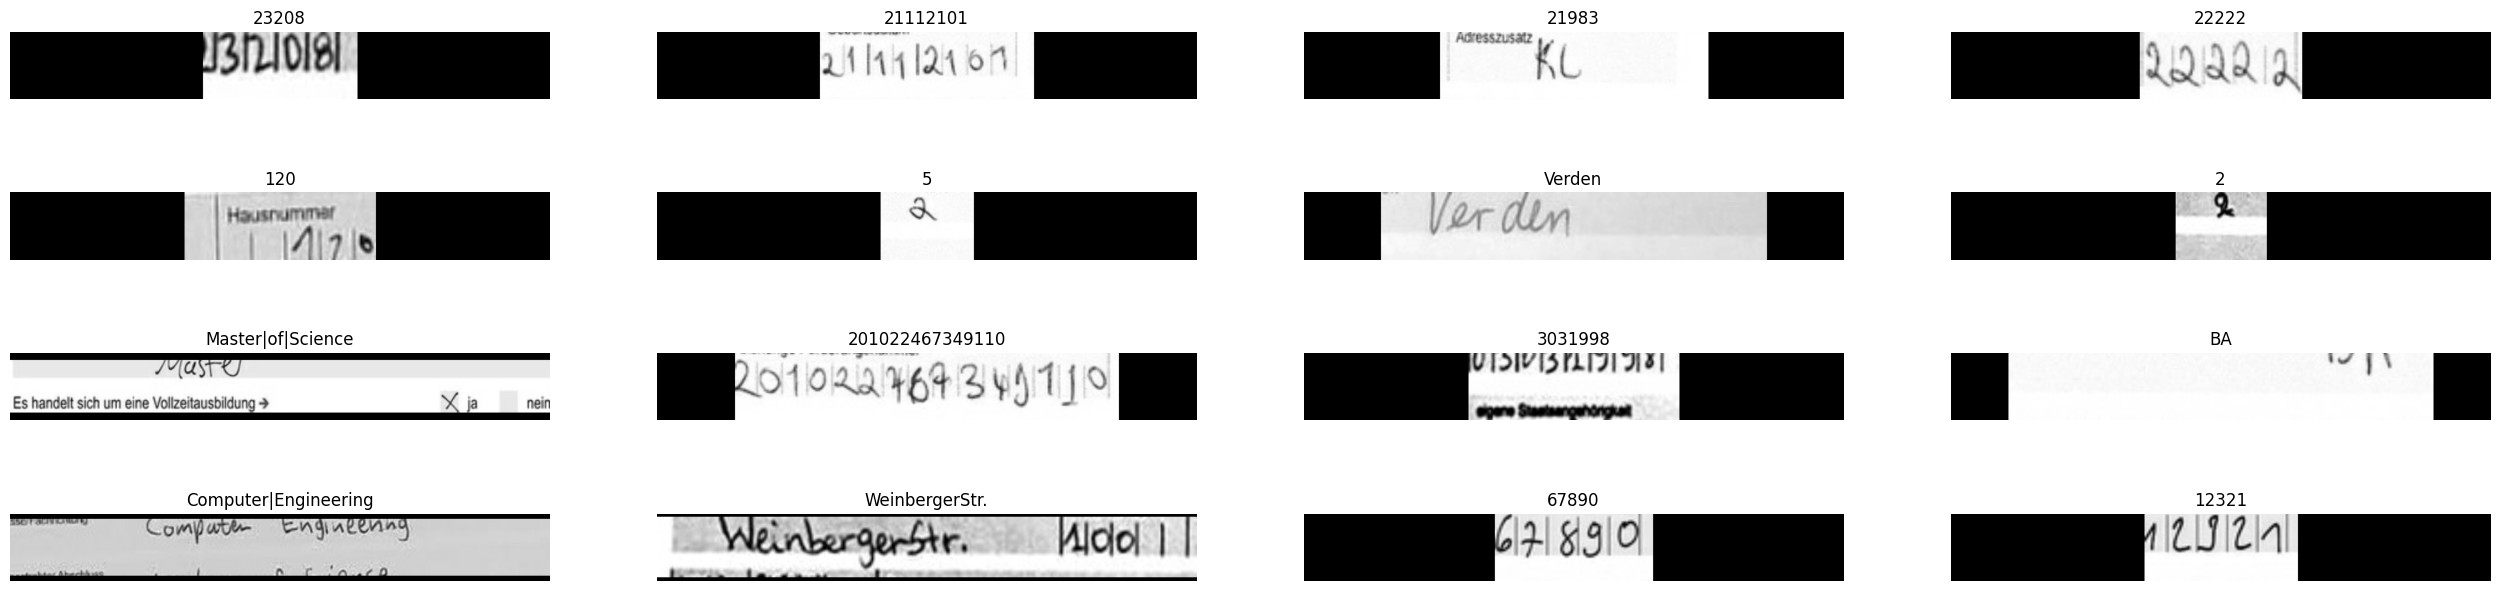

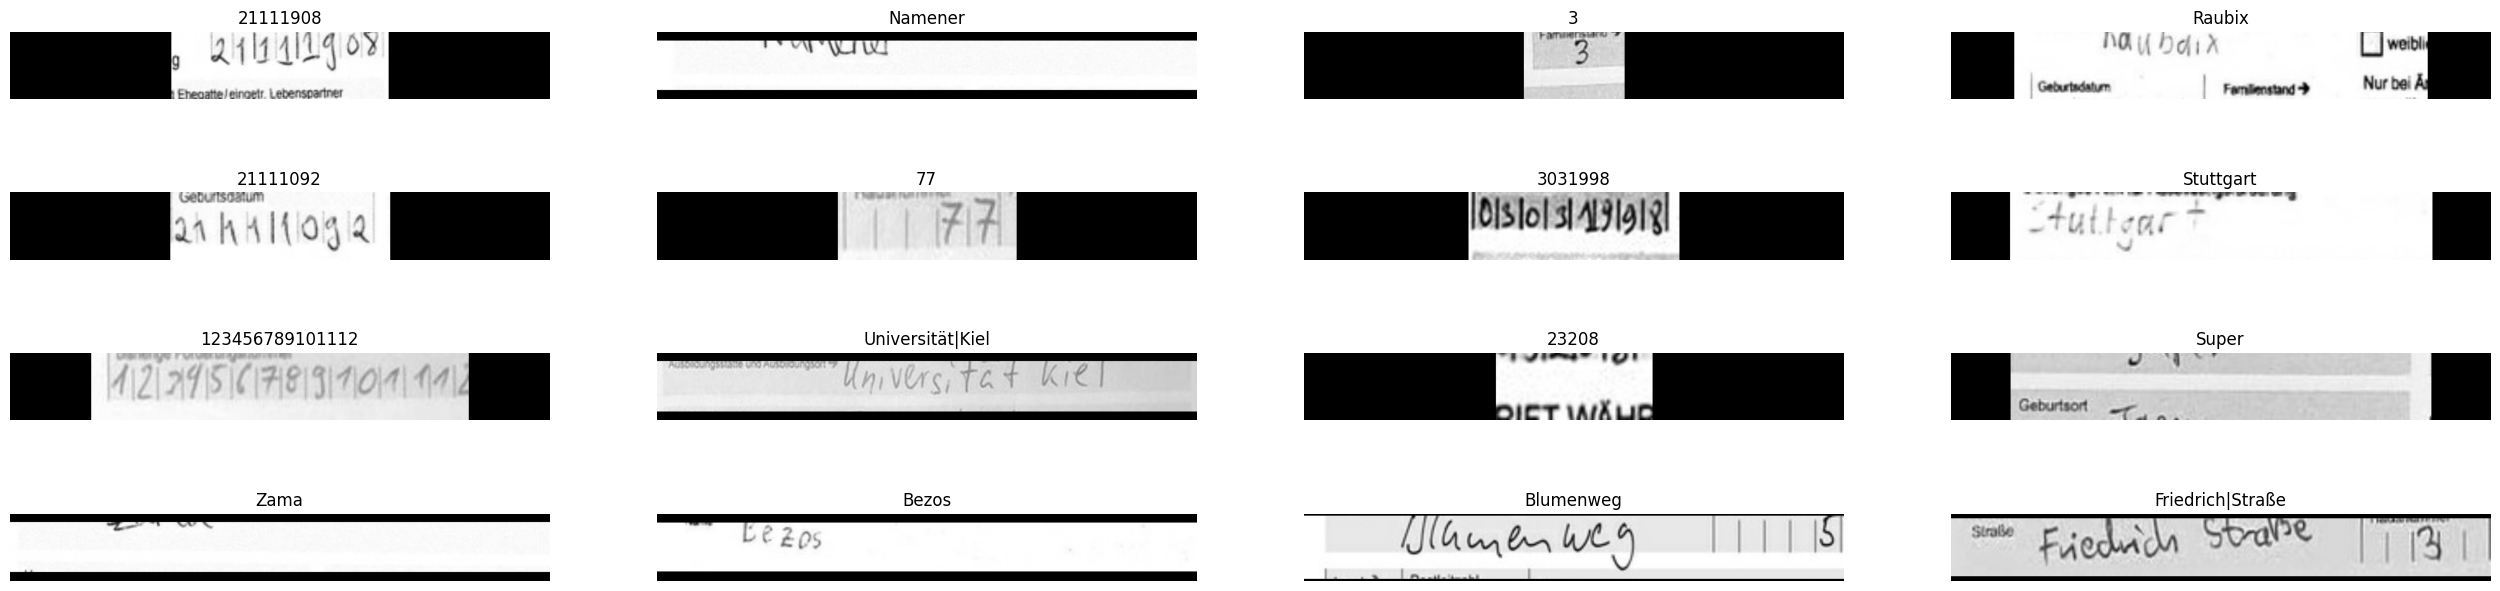

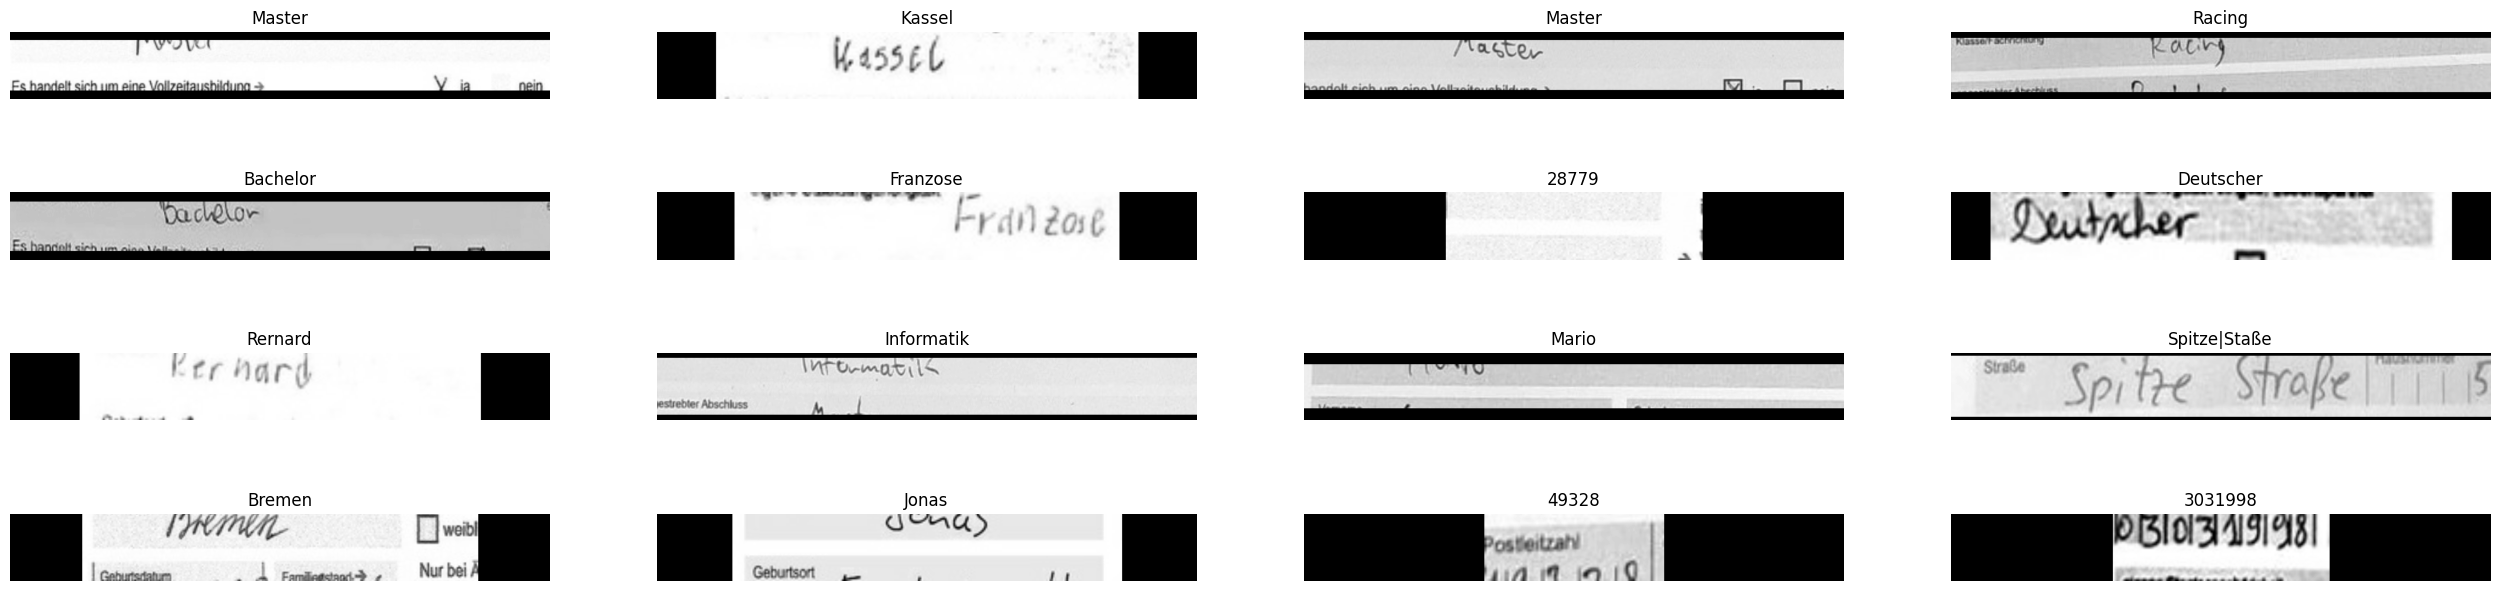

In [39]:
for data in train_ds.take(3):
    images, labels = data["image"], data["label"]

    ax = plt.subplots(4, 4, figsize=(32, 8))[1]

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, tokenizer.padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(tokenizer.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [9]:
print(load_transfer_data.max_len)
print(load_transfer_data.characters)

47
[',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', 'Ä', 'Ö', 'ß', 'ä', 'ö', 'ü']


# Data Augmentation

In [ ]:
# # To see the augmentations from CustomImageGenerator
# train_generator = cgi.CustomImageGenerator(x_train_img_paths, y_train_labels, tokenizer.batch_size, IMAGE_WIDTH, IMAGE_HEIGHT)
# 
# example_batch = train_generator[0]
# augmented_images = example_batch[0]['image']
# 
# num_to_plot = 4
# fig, axes = plt.subplots(1, num_to_plot, figsize=(10, 10))
# 
# for i, ax in enumerate(axes.flatten()):
#     ax.imshow(np.squeeze(augmented_images[i]), cmap='gray')
#     ax.axis('off')
# 
# plt.tight_layout()
# plt.show()

In [ ]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomBrightness(0.5,value_range=(0, 1), seed=TF_SEED),
        tf.keras.layers.RandomContrast(0.5,seed=TF_SEED)
    ]
)

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 4, 1)
plt.imshow(images[0].numpy(), cmap='gray', vmin=0, vmax=1)
plt.title("Original Image")

# Apply data augmentation to the image
augmented_images = data_augmentation(images, training=True)

# Display the augmented images
for i in range(3):
    plt.subplot(1, 4, i + 2)
    plt.imshow(augmented_images[i].numpy(), cmap='gray', vmin=0, vmax=1)
    plt.title(f"Augmented Image {i+1}")
    
plt.show()

# Train Keras Model

In [ ]:
weights_keras_string ="_weights.keras"

def model_load_weights_if_exists(model):
    MODEL_MODEL_PATH = MODEL_NAME
    MODEL_WEIGHT_PATH = MODEL_NAME + weights_keras_string
    model_path = os.path.join(MODEL_DIR_NAME, MODEL_MODEL_PATH)
    model_weight_path = os.path.join(model_path, MODEL_WEIGHT_PATH)
    print(model_path)
    if os.path.exists(model_path):
        print("Resuming Training where we left off!")
        model.load_weights(model_weight_path)

In [ ]:
def train_model(model):
    #model_load_weights_if_exists(model)
        
    prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
    # checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
    early_stopping = EarlyStopping(patience=PATIENCE, restore_best_weights=True)

    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=1e-9, verbose=10)
    # history = model.fit(train_ds, validation_data=val_ds, epochs=500, callbacks=[reduce_lr, early_stopping])    
    history = model.fit(train_ds, validation_data=val_ds, epochs=500)   
    return prediction_model, history

# Transfer Model

In [ ]:
from keras.models import load_model
def load_model_and_weights():
    weights_keras_string = "_weights.keras"
    MODEL_MODEL_PATH = MODEL_NAME
    MODEL_WEIGHT_PATH = MODEL_NAME + weights_keras_string
    model_path = os.path.join(MODEL_DIR_NAME, MODEL_MODEL_PATH)
    model_weight_path = os.path.join(model_path, MODEL_WEIGHT_PATH)
    model_weight_path = "./handwriting/models/model9v3_xl/model9v3_xl_weights.keras"
    model_path = "./handwriting/models/model9v3_xl"
    print(model_path)
    if os.path.exists(model_path):
        print("Loading pre-trained model and weights...")
        model = load_model(model_path)
        model.load_weights(model_weight_path)
        print("Model and weights loaded successfully.")

        return model
    else:
        print("No pre-trained model or weights found.")
        return None

In [ ]:
model = load_model_and_weights()
char = len(tokenizer.char_to_num.get_vocabulary())
model = testing_models.load_and_finetune_model2(model, IMAGE_WIDTH, IMAGE_HEIGHT, char, LEARNING_RATE)
model.summary()

In [ ]:
start_time = time.time()

prediction_model, history = train_model(model)

total_duration = time.time() - start_time
print("Gesamte Trainingsdauer: {time}s".format(time=round(total_duration)))

# Plot helper functions

In [ ]:
def plot_history(history, name, dir_path, save_fig):
    """
    Plottet die Historie des Trainings eines Models und speichert die in einem Verzeichnis ab 

    :param history: Das trainierte Modell
    :param name: Name, wie das Modell gespeicht werden soll
    :param name: Verzeichniss, wo der Plot gespeichert weren soll
    :return: void
    """
    metrics = history.history
    _, ax1 = plt.subplots()

    # Plot für Trainings- und Validierungsverluste
    ax1.plot(metrics['loss'], label='Training Loss', color='blue')
    ax1.plot(metrics['val_loss'], label='Validation Loss', color='red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='black')
    ax1.tick_params('y', colors='black')
    ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 0.95))  

    # Zweite Y-Achse für die Lernrate
    ax2 = ax1.twinx()
    ax2.plot(metrics['lr'], label='Learning Rate', color='green')
    ax2.set_ylabel('Learning Rate', color='black')
    
    ax2.set_yscale('log')  # Verwende logarithmische Skala für die Lernrate
    
    ax2.tick_params('y', colors='black')
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:1.0e}'))
    ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))  
    
    if save_fig:
        plt.title('Name: '+name)
        path = os.path.join(dir_path, name + '_history.png')
        plt.savefig(path)
        
    plt.show()

In [ ]:
def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :load_transfer_data.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
def plot_evaluation(name, dir_path, save_fig):
    for batch in val_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 8))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(16):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")   
    if save_fig:
        path = os.path.join(dir_path, name + '_result.png')
        plt.savefig(path)
        
    plt.show()

# Model Testing

In [ ]:
def create_new_plot_name(model_name, names, format):
    import re
    pattern = r"\d+"
    max_number = 0
    for name in names:
        tmp_name = name.replace(model_name,"")
        number = int(re.findall(pattern,tmp_name)[0])
        if number > max_number:
            max_number = number
            
    new_model_name = model_name + "V_" + str(max_number + 1)
    return format.replace(model_name,new_model_name)
        
if not os.path.exists(TEST_RESULT_DIR_NAME):
            create_dir(TEST_RESULT_DIR_NAME)
files_with_model_name = [file for file in os.listdir(TEST_RESULT_DIR_NAME) if MODEL_NAME in file]
metrics = history.history

NAME = "{name}_{epoch}E_{height}H_{width}W_{loss}L_{val_loss}VL_{time}s".format(
    name=MODEL_NAME, epoch=history.epoch[-1], height=IMAGE_HEIGHT, width=IMAGE_WIDTH,
    loss=round(metrics['loss'][-1],2), val_loss=round(metrics['val_loss'][-1], 2), time=round(total_duration))

if not files_with_model_name:
    if SAVE_HISTORY:
        plot_history(history, NAME, TEST_RESULT_DIR_NAME, True)
        plot_evaluation(NAME, TEST_RESULT_DIR_NAME, True)
else:
    new_name = create_new_plot_name(MODEL_NAME,files_with_model_name, NAME)
    plot_history(history, new_name, TEST_RESULT_DIR_NAME, True)
    plot_evaluation(new_name, TEST_RESULT_DIR_NAME, True)

# Save the Model

In [ ]:
if MODEL_SAVE:
    if not os.path.exists(MODEL_DIR_NAME):
        create_dir(MODEL_DIR_NAME)
    model_path = os.path.join(MODEL_DIR_NAME, "{model_name}".format(model_name=MODEL_NAME))
    model.save(model_path)
    model.save_weights(os.path.join(model_path, f"{MODEL_NAME}{weights_keras_string}"), overwrite=True, save_format=None, options=None)
    json_string = model.to_json()

    with open(os.path.join(model_path, f"{MODEL_NAME}.json"),'w') as f:
        f.write(json_string)